In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

import optuna

In [2]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TARGET_NAME = 'TARGET' # Target column name

In [3]:
DATASET_DIR = './example_data/test_data_files'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

In [4]:
data = pd.read_csv(DATASET_FULLNAME)
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 9.3+ MB


In [6]:
data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data['constant'] = 1
data['allnan'] = np.nan

data['report_dt'] = np.datetime64('2018-01-01')

data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

![AutoML pipeline for this task](imgs/tutorial_1_pipeline.png)

### SimpleFeatures for TreeBasedModel

- Numeric stay as is, Datetime transforms to numeric.
- Categorical label encoding.
- Maps input to output features exactly one-to-one.

In [7]:
numerical_columns = data._get_numeric_data().columns
date_columns = ['BIRTH_DATE', 'EMP_DATE']
categorycal_columns = list(set(data.columns) - set(numerical_columns) - set(date_columns))

In [8]:
df = data.copy()

In [9]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,2018-01-01
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,2018-01-01
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,2018-01-01
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,2018-01-01
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,2018-01-01


#### LavelEncoding

In [10]:
for cat_col in categorycal_columns:
    le = LabelEncoder()
    df[cat_col] = le.fit_transform(df[cat_col])

In [11]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,0,1,0,1,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,0
1,319656,0,0,0,0,0,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,0
2,207678,0,1,0,1,1,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,0
3,381593,0,0,0,0,0,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,0
4,258153,0,0,0,1,1,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,0


#### One-Hot-Encoding

In [10]:
for cat_col in categorycal_columns:
    le = OneHotEncoder(handle_unknown='error', drop='if_binary')
    a = le.fit_transform(df[[cat_col]]).toarray()
    shift = df.columns[-1]
    if not isinstance(shift, int):
        shift = 0
    end_col = pd.DataFrame(data=a, columns=np.arange(a.shape[1]) + shift + 1)
    df = df.join(end_col)
    df.drop(axis=1, inplace=True, columns=[cat_col])

In [175]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,0,1,0,1,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,0
1,319656,0,0,0,0,0,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,0
2,207678,0,1,0,1,1,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,0
3,381593,0,0,0,0,0,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,0
4,258153,0,0,0,1,1,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,0


#### Datetime to numeric

In [12]:
basic_time = '2020-01-01'
basic_interval = 'D'

for date_col in date_columns:
    df[date_col] = pd.to_datetime(df[date_col])
    df[date_col] = ((df[date_col] - np.datetime64(basic_time)) / np.timedelta64(1, basic_interval)).values.astype(np.float32)

# ------------------------------

### ImportanceBasedFeatureSelector

In [13]:
train_labels = df['TARGET']
df.drop(columns=['TARGET'], axis=1, inplace=True)
train = df
num_feats = len(train.columns)

In [17]:
lgbc=LGBMClassifier(learning_rate=0.05, num_leaves=64)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(train, train_labels)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

29 selected features


In [18]:
df = df[embeded_lgb_feature]
df.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,...,LIVINGAREA_AVG,BASEMENTAREA_MODE,COMMONAREA_MODE,LANDAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE
0,313802,270000.0,327024.0,15372.0,270000.0,0.072508,-2432.0,-2137,NaN,6,...,0.0672,0.0000,0.0248,0.0000,0.0686,0.0,-1275.0,1.0,-19320.0,-956.0
1,319656,108000.0,675000.0,19737.0,675000.0,0.035792,-13156.0,-3758,NaN,16,...,NaN,NaN,NaN,NaN,NaN,1.0,-1732.0,0.0,-21046.0,-4552.0
2,207678,112500.0,270000.0,13500.0,270000.0,0.031329,-4077.0,-1058,18.0,8,...,0.0023,NaN,NaN,NaN,0.0018,4.0,-1597.0,1.0,-10275.0,-1806.0
3,381593,67500.0,142200.0,9630.0,112500.0,0.008474,-5106.0,-1556,NaN,18,...,0.0337,0.0000,NaN,0.0212,0.0214,0.0,-1069.0,4.0,-12151.0,-3002.0
4,258153,337500.0,1483231.5,46570.5,1354500.0,0.008474,-5743.0,-4256,9.0,10,...,0.0863,0.0816,0.0121,0.0981,0.0753,0.0,-1104.0,0.0,-13933.0,-2505.0


#### First level models

In [20]:
train_features, test_features, train_target, test_target = train_test_split(df, train_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_full_features, test_full_features = train_test_split(train, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_features

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,...,LIVINGAREA_AVG,BASEMENTAREA_MODE,COMMONAREA_MODE,LANDAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE
9254,445173,162000.0,619254.0,29920.5,553500.0,0.018634,-11124.0,-1885,NaN,11,...,NaN,NaN,NaN,NaN,NaN,6.0,-1527.0,4.0,-12299.0,-1711.0
1561,120419,202500.0,805536.0,36531.0,720000.0,0.010147,-7349.0,-1977,NaN,10,...,0.0740,0.0567,0.0451,0.0167,0.0827,3.0,-281.0,2.0,-19199.0,-4915.0
1670,266087,157500.0,505332.0,35298.0,477000.0,0.018850,-9707.0,-2275,5.0,0,...,NaN,NaN,NaN,NaN,NaN,9.0,-2.0,1.0,-19446.0,-2813.0
6087,200021,202500.0,260640.0,27499.5,225000.0,0.031329,-5322.0,-3113,NaN,6,...,NaN,NaN,NaN,NaN,NaN,0.0,-1853.0,2.0,-11454.0,-3804.0
6669,120701,54000.0,269550.0,13891.5,225000.0,0.030755,-1524.0,-2197,NaN,6,...,NaN,NaN,NaN,NaN,NaN,0.0,-719.0,NaN,-19382.0,-1702.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,234579,162000.0,891072.0,35469.0,720000.0,0.007305,-10858.0,-4592,NaN,18,...,0.2433,0.1165,0.0387,0.1262,0.2273,0.0,-1409.0,NaN,-23418.0,-730.0
5191,418107,180000.0,243000.0,23800.5,243000.0,0.020246,-6677.0,-4472,11.0,3,...,NaN,NaN,NaN,NaN,NaN,1.0,-1835.0,4.0,-16790.0,-8458.0
5390,296083,247500.0,360000.0,28440.0,360000.0,0.035792,-1632.0,-2009,16.0,10,...,NaN,NaN,NaN,NaN,NaN,0.0,-1103.0,3.0,-19193.0,-1856.0
860,103189,225000.0,277969.5,15957.0,229500.0,0.008230,-7772.0,-4929,NaN,4,...,NaN,NaN,NaN,NaN,NaN,1.0,-254.0,2.0,-15925.0,-1194.0


In [49]:
default_params = {
    'task': 'train',
    "learning_rate": 0.01,
    "num_leaves": 24,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    'bagging_freq': 1,
    "max_depth": -1,
    "verbosity": -1,
    "reg_alpha": 0.5,
    "reg_lambda": 0.0,
    "min_split_gain": 0.0,
    'zero_as_missing': False,
    'num_threads': 4,
    'max_bin': 255,
    'min_data_in_bin': 3,
    'num_trees': 3000,
    'random_state': 42,
    'early_stopping_rounds': 200
}
# **default_params
lgbc=LGBMClassifier(**default_params)
lgbc.fit(train_features, train_target, eval_set=(test_features, test_target), eval_metric = 'auc')
LGBM_predicted_train = lgbc.predict(train_features)
LGBM_predicted_test = lgbc.predict(test_features)

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.697715	valid_0's binary_logloss: 0.260229
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.695992	valid_0's binary_logloss: 0.259885
[3]	valid_0's auc: 0.705047	valid_0's binary_logloss: 0.259496
[4]	valid_0's auc: 0.705352	valid_0's binary_logloss: 0.259171
[5]	valid_0's auc: 0.70759	valid_0's binary_logloss: 0.258739
[6]	valid_0's auc: 0.705668	valid_0's binary_logloss: 0.258372
[7]	valid_0's auc: 0.71668	valid_0's binary_logloss: 0.258032
[8]	valid_0's auc: 0.710955	valid_0's binary_logloss: 0.257901
[9]	valid_0's auc: 0.710098	valid_0's binary_logloss: 0.257654
[10]	valid_0's auc: 0.715516	valid_0's binary_logloss: 0.257182
[11]	valid_0's auc: 0.71657	valid_0's binary_logloss: 0.256949
[12]	valid_0's auc: 0.71858	valid_0's binary_logloss: 0.256549
[13]	valid_0's auc: 0.71787	valid_0's binary_logloss: 0.256254
[14]	valid_0's auc: 0.720829	valid_0's binary_logloss: 0.255853
[15]	valid_0's auc: 0.718624	valid_0's binary_logloss: 0

In [ ]:
# cross vaidation

In [55]:
def objective(trial):
    
    dtrain = lgb.Dataset(train_features, label = train_target, free_raw_data = False)
    dtest  = lgb.Dataset(test_features, label = test_target, free_raw_data = False)
    
    param = {
        'task': 'train',
        "learning_rate": 0.01,
        'bagging_freq': 1,
        "max_depth": -1,
        "verbosity": -1,
        "reg_alpha": 0.5,
        "reg_lambda": 0.0,
        "min_split_gain": 0.0,
        'zero_as_missing': False,
        'num_threads': 4,
        'max_bin': 255,
        'min_data_in_bin': 3,
        'num_trees': 3000,
        'random_state': 42,
        'early_stopping_rounds': 200,
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'metric': 'auc',
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0)
    }
    
    # Add a callback for pruning
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
    
    gbm = lgb.train(
        param, 
        dtrain, 
        verbose_eval = 20,
        valid_sets = [dtest],
        callbacks = [pruning_callback]
        )
    
    preds = gbm.predict(test_features)
    accuracy = np.sqrt(mean_squared_error(test_target, preds))

    return accuracy



study = optuna.create_study(direction = 'maximize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
study.optimize(objective, n_trials = 100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-07-15 10:51:32,411] A new study created in memory with name: no-name-6bf1b0ca-55fc-49bc-bfd0-1b32495fe621


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.706415
[40]	valid_0's auc: 0.702909
[60]	valid_0's auc: 0.704668
[80]	valid_0's auc: 0.700928
[100]	valid_0's auc: 0.705218
[120]	valid_0's auc: 0.703248
[140]	valid_0's auc: 0.703824
[160]	valid_0's auc: 0.705378
[180]	valid_0's auc: 0.70185
[200]	valid_0's auc: 0.70163
[220]	valid_0's auc: 0.701039
[240]	valid_0's auc: 0.701909
[260]	valid_0's auc: 0.701891
[280]	valid_0's auc: 0.700586
[300]	valid_0's auc: 0.699177
Early stopping, best iteration is:
[109]	valid_0's auc: 0.707627


[I 2021-07-15 10:51:34,330] Trial 0 finished with value: 0.2538384195680353 and parameters: {'num_leaves': 154, 'feature_fraction': 0.6941606421019623, 'bagging_fraction': 0.8635928136931721, 'min_sum_hessian_in_leaf': 1.5739587823659569}. Best is trial 0 with value: 0.2538384195680353.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.72068
[40]	valid_0's auc: 0.717191
[60]	valid_0's auc: 0.716752
[80]	valid_0's auc: 0.721006
[100]	valid_0's auc: 0.720784
[120]	valid_0's auc: 0.721535
[140]	valid_0's auc: 0.722461
[160]	valid_0's auc: 0.720911
[180]	valid_0's auc: 0.720108
[200]	valid_0's auc: 0.719691
[220]	valid_0's auc: 0.72039
[240]	valid_0's auc: 0.719517


[I 2021-07-15 10:51:34,949] Trial 1 finished with value: 0.2532777006092339 and parameters: {'num_leaves': 34, 'feature_fraction': 0.5286061846786495, 'bagging_fraction': 0.932754477117222, 'min_sum_hessian_in_leaf': 0.038069430442823925}. Best is trial 0 with value: 0.2538384195680353.


[260]	valid_0's auc: 0.719197
[280]	valid_0's auc: 0.719413
[300]	valid_0's auc: 0.719859
[320]	valid_0's auc: 0.719394
Early stopping, best iteration is:
[134]	valid_0's auc: 0.723658
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's auc: 0.710767
[40]	valid_0's auc: 0.713979
[60]	valid_0's auc: 0.715743
[80]	valid_0's auc: 0.717275
[100]	valid_0's auc: 0.717818
[120]	valid_0's auc: 0.716018
[140]	valid_0's auc: 0.71629
[160]	valid_0's auc: 0.71468
[180]	valid_0's auc: 0.713921
[200]	valid_0's auc: 0.713676
[220]	valid_0's auc: 0.711419


[I 2021-07-15 10:51:36,180] Trial 2 finished with value: 0.25373871620559846 and parameters: {'num_leaves': 65, 'feature_fraction': 0.9899668043590711, 'bagging_fraction': 0.6355486436706936, 'min_sum_hessian_in_leaf': 0.013375817745107885}. Best is trial 0 with value: 0.2538384195680353.


[240]	valid_0's auc: 0.710438
[260]	valid_0's auc: 0.710215
Early stopping, best iteration is:
[78]	valid_0's auc: 0.718528
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's auc: 0.712979
[40]	valid_0's auc: 0.722508
[60]	valid_0's auc: 0.721788
[80]	valid_0's auc: 0.721948
[100]	valid_0's auc: 0.721219
[120]	valid_0's auc: 0.724116
[140]	valid_0's auc: 0.724826
[160]	valid_0's auc: 0.727068
[180]	valid_0's auc: 0.726395
[200]	valid_0's auc: 0.724855
[220]	valid_0's auc: 0.725551
[240]	valid_0's auc: 0.725365
[260]	valid_0's auc: 0.722692
[280]	valid_0's auc: 0.722309


[I 2021-07-15 10:51:37,101] Trial 3 finished with value: 0.25241777060350934 and parameters: {'num_leaves': 43, 'feature_fraction': 0.6276022990616079, 'bagging_fraction': 0.7855693767554848, 'min_sum_hessian_in_leaf': 0.04115874052987109}. Best is trial 0 with value: 0.2538384195680353.


[300]	valid_0's auc: 0.723049
[320]	valid_0's auc: 0.721807
[340]	valid_0's auc: 0.721904
[360]	valid_0's auc: 0.7211
Early stopping, best iteration is:
[173]	valid_0's auc: 0.72764
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's auc: 0.689607
[40]	valid_0's auc: 0.707021
[60]	valid_0's auc: 0.700831
[80]	valid_0's auc: 0.699809
[100]	valid_0's auc: 0.701006
[120]	valid_0's auc: 0.701905
[140]	valid_0's auc: 0.707519
[160]	valid_0's auc: 0.705772
[180]	valid_0's auc: 0.705344


[I 2021-07-15 10:51:38,133] Trial 4 finished with value: 0.25630128285764187 and parameters: {'num_leaves': 99, 'feature_fraction': 0.5626689757582953, 'bagging_fraction': 0.9668039540291191, 'min_sum_hessian_in_leaf': 0.08651021662566526}. Best is trial 4 with value: 0.25630128285764187.


[200]	valid_0's auc: 0.705564
[220]	valid_0's auc: 0.704902
Early stopping, best iteration is:
[38]	valid_0's auc: 0.709839


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 10:51:38,238] Trial 5 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.703147
[40]	valid_0's auc: 0.716966
[60]	valid_0's auc: 0.713762
[80]	valid_0's auc: 0.711423
[100]	valid_0's auc: 0.711245
[120]	valid_0's auc: 0.708791
[140]	valid_0's auc: 0.710999
[160]	valid_0's auc: 0.709419
[180]	valid_0's auc: 0.708304
[200]	valid_0's auc: 0.705333


[I 2021-07-15 10:51:39,570] Trial 6 finished with value: 0.25587700882647163 and parameters: {'num_leaves': 129, 'feature_fraction': 0.676122414479043, 'bagging_fraction': 0.6944117888903211, 'min_sum_hessian_in_leaf': 0.8133036543630687}. Best is trial 4 with value: 0.25630128285764187.


[220]	valid_0's auc: 0.703556
Early stopping, best iteration is:
[39]	valid_0's auc: 0.719639
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 10:51:39,664] Trial 7 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:39,785] Trial 8 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:39,888] Trial 9 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:39,981] Trial 10 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:40,070] Trial 11 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:40,143] Trial 12 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:40,237] Trial 13 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:40,310] Trial 14 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:40,423] Trial 15 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:40,510] Trial 16 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.723207
[40]	valid_0's auc: 0.730904
[60]	valid_0's auc: 0.732596
[80]	valid_0's auc: 0.732358
[100]	valid_0's auc: 0.732494
[120]	valid_0's auc: 0.732378
[140]	valid_0's auc: 0.731748
[160]	valid_0's auc: 0.733306
[180]	valid_0's auc: 0.734652
[200]	valid_0's auc: 0.735098
[220]	valid_0's auc: 0.735061
[240]	valid_0's auc: 0.735998
[260]	valid_0's auc: 0.736968
[280]	valid_0's auc: 0.736451
[300]	valid_0's auc: 0.736291
[320]	valid_0's auc: 0.734968
[340]	valid_0's auc: 0.734503


[I 2021-07-15 10:51:41,298] Trial 17 finished with value: 0.2516568646003215 and parameters: {'num_leaves': 18, 'feature_fraction': 0.6733537799377984, 'bagging_fraction': 0.5927102619922919, 'min_sum_hessian_in_leaf': 0.08572670582018449}. Best is trial 4 with value: 0.25630128285764187.


[360]	valid_0's auc: 0.73515
[380]	valid_0's auc: 0.735031
[400]	valid_0's auc: 0.734726
[420]	valid_0's auc: 0.735321
[440]	valid_0's auc: 0.736254
Early stopping, best iteration is:
[257]	valid_0's auc: 0.737228
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 10:51:41,388] Trial 18 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:41,466] Trial 19 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 10:51:41,551] Trial 20 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:41,637] Trial 21 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:41,744] Trial 22 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:41,830] Trial 23 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:41,942] Trial 24 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:42,020] Trial 25 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:42,093] Trial 26 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:42,155] Trial 27 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:42,265] Trial 28 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.719591
[40]	valid_0's auc: 0.724658
[60]	valid_0's auc: 0.724422
[80]	valid_0's auc: 0.724209
[100]	valid_0's auc: 0.725874
[120]	valid_0's auc: 0.724409
[140]	valid_0's auc: 0.726361
[160]	valid_0's auc: 0.724978
[180]	valid_0's auc: 0.72419
[200]	valid_0's auc: 0.72445
[220]	valid_0's auc: 0.723729
[240]	valid_0's auc: 0.722766
[260]	valid_0's auc: 0.721138
[280]	valid_0's auc: 0.721376
[300]	valid_0's auc: 0.7211
[320]	valid_0's auc: 0.720015


[I 2021-07-15 10:51:43,102] Trial 29 pruned. Trial was pruned at iteration 334.
[I 2021-07-15 10:51:43,197] Trial 30 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:43,264] Trial 31 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:43,324] Trial 32 pruned. Trial was pruned at iteration 11.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:43,388] Trial 33 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:43,457] Trial 34 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:43,535] Trial 35 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:43,668] Trial 36 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:43,749] Trial 37 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:43,827] Trial 38 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:43,935] Trial 39 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:44,055] Trial 40 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.726956
[40]	valid_0's auc: 0.721528
[60]	valid_0's auc: 0.717859
[80]	valid_0's auc: 0.718632
[100]	valid_0's auc: 0.717691
[120]	valid_0's auc: 0.720264
[140]	valid_0's auc: 0.720283
[160]	valid_0's auc: 0.721688


[I 2021-07-15 10:51:44,484] Trial 41 finished with value: 0.25765519513290225 and parameters: {'num_leaves': 31, 'feature_fraction': 0.5013743719376683, 'bagging_fraction': 0.9295091350746283, 'min_sum_hessian_in_leaf': 0.02931958056167553}. Best is trial 41 with value: 0.25765519513290225.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 10:51:44,546] Trial 42 pruned. Trial was pruned at iteration 10.


[180]	valid_0's auc: 0.721052
[200]	valid_0's auc: 0.719045
[220]	valid_0's auc: 0.720309
Early stopping, best iteration is:
[20]	valid_0's auc: 0.726956
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:44,626] Trial 43 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:44,708] Trial 44 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:44,790] Trial 45 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:44,877] Trial 46 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:44,956] Trial 47 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:45,059] Trial 48 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:45,133] Trial 49 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.717976
[40]	valid_0's auc: 0.723653
[60]	valid_0's auc: 0.726871
[80]	valid_0's auc: 0.727235
[100]	valid_0's auc: 0.728819
[120]	valid_0's auc: 0.728456
[140]	valid_0's auc: 0.729408
[160]	valid_0's auc: 0.73088
[180]	valid_0's auc: 0.73083
[200]	valid_0's auc: 0.730875
[220]	valid_0's auc: 0.732574
[240]	valid_0's auc: 0.731213
[260]	valid_0's auc: 0.728874


[I 2021-07-15 10:51:45,738] Trial 50 pruned. Trial was pruned at iteration 373.
[I 2021-07-15 10:51:45,791] Trial 51 pruned. Trial was pruned at iteration 11.


[280]	valid_0's auc: 0.728503
[300]	valid_0's auc: 0.729205
[320]	valid_0's auc: 0.728551
[340]	valid_0's auc: 0.727592
[360]	valid_0's auc: 0.727372
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:45,897] Trial 52 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:46,017] Trial 53 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:46,088] Trial 54 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:46,173] Trial 55 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:46,270] Trial 56 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.716922
[40]	valid_0's auc: 0.720556
[60]	valid_0's auc: 0.71945
[80]	valid_0's auc: 0.718885
[100]	valid_0's auc: 0.718416
[120]	valid_0's auc: 0.718887
[140]	valid_0's auc: 0.721556
[160]	valid_0's auc: 0.721744
[180]	valid_0's auc: 0.721671
[200]	valid_0's auc: 0.722627
[220]	valid_0's auc: 0.723848
[240]	valid_0's auc: 0.724718


[I 2021-07-15 10:51:46,837] Trial 57 pruned. Trial was pruned at iteration 334.


[260]	valid_0's auc: 0.725755
[280]	valid_0's auc: 0.725911
[300]	valid_0's auc: 0.726305
[320]	valid_0's auc: 0.726001
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:46,937] Trial 58 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:46,998] Trial 59 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:47,072] Trial 60 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:47,128] Trial 61 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.721561
[40]	valid_0's auc: 0.720837
[60]	valid_0's auc: 0.723684
[80]	valid_0's auc: 0.722275
[100]	valid_0's auc: 0.723223
[120]	valid_0's auc: 0.722978
[140]	valid_0's auc: 0.725673
[160]	valid_0's auc: 0.727696
[180]	valid_0's auc: 0.727421
[200]	valid_0's auc: 0.727685
[220]	valid_0's auc: 0.727633
[240]	valid_0's auc: 0.726971
[260]	valid_0's auc: 0.726919
[280]	valid_0's auc: 0.727127
[300]	valid_0's auc: 0.726945
[320]	valid_0's auc: 0.726238
[340]	valid_0's auc: 0.727317


[I 2021-07-15 10:51:47,930] Trial 62 pruned. Trial was pruned at iteration 373.
[I 2021-07-15 10:51:47,998] Trial 63 pruned. Trial was pruned at iteration 10.


[360]	valid_0's auc: 0.727662
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:48,109] Trial 64 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.721792
[40]	valid_0's auc: 0.728592
[60]	valid_0's auc: 0.726584
[80]	valid_0's auc: 0.726391
[100]	valid_0's auc: 0.727276
[120]	valid_0's auc: 0.727975
[140]	valid_0's auc: 0.728811
[160]	valid_0's auc: 0.72999
[180]	valid_0's auc: 0.731328
[200]	valid_0's auc: 0.731012
[220]	valid_0's auc: 0.730785
[240]	valid_0's auc: 0.733912
[260]	valid_0's auc: 0.733488
[280]	valid_0's auc: 0.732975
[300]	valid_0's auc: 0.732399


[I 2021-07-15 10:51:48,961] Trial 65 pruned. Trial was pruned at iteration 373.
[I 2021-07-15 10:51:49,055] Trial 66 pruned. Trial was pruned at iteration 10.


[320]	valid_0's auc: 0.731057
[340]	valid_0's auc: 0.729845
[360]	valid_0's auc: 0.730599
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:49,156] Trial 67 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:49,250] Trial 68 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:49,307] Trial 69 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:49,400] Trial 70 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.721649
[40]	valid_0's auc: 0.733213
[60]	valid_0's auc: 0.732154
[80]	valid_0's auc: 0.731715
[100]	valid_0's auc: 0.731083
[120]	valid_0's auc: 0.729053
[140]	valid_0's auc: 0.730547
[160]	valid_0's auc: 0.73209
[180]	valid_0's auc: 0.73318
[200]	valid_0's auc: 0.732905
[220]	valid_0's auc: 0.733035
[240]	valid_0's auc: 0.733183
[260]	valid_0's auc: 0.734154
[280]	valid_0's auc: 0.733068
[300]	valid_0's auc: 0.732246
[320]	valid_0's auc: 0.731365


[I 2021-07-15 10:51:50,063] Trial 71 pruned. Trial was pruned at iteration 373.
[I 2021-07-15 10:51:50,118] Trial 72 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:50,200] Trial 73 pruned. Trial was pruned at iteration 10.


[340]	valid_0's auc: 0.730194
[360]	valid_0's auc: 0.729722
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:50,286] Trial 74 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:50,354] Trial 75 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.718065
[40]	valid_0's auc: 0.721128
[60]	valid_0's auc: 0.722028
[80]	valid_0's auc: 0.723556
[100]	valid_0's auc: 0.724841
[120]	valid_0's auc: 0.724426
[140]	valid_0's auc: 0.726971
[160]	valid_0's auc: 0.727071
[180]	valid_0's auc: 0.727413
[200]	valid_0's auc: 0.727726
[220]	valid_0's auc: 0.728663
[240]	valid_0's auc: 0.7288
[260]	valid_0's auc: 0.729324
[280]	valid_0's auc: 0.729432
[300]	valid_0's auc: 0.729886
[320]	valid_0's auc: 0.729283
[340]	valid_0's auc: 0.729808


[I 2021-07-15 10:51:50,913] Trial 76 pruned. Trial was pruned at iteration 373.
[I 2021-07-15 10:51:50,968] Trial 77 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:51,018] Trial 78 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:51,092] Trial 79 pruned. Trial was pruned at iteration 10.


[360]	valid_0's auc: 0.729328
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:51,157] Trial 80 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.724021
[40]	valid_0's auc: 0.72925
[60]	valid_0's auc: 0.729752
[80]	valid_0's auc: 0.730523
[100]	valid_0's auc: 0.731001
[120]	valid_0's auc: 0.732176
[140]	valid_0's auc: 0.730573
[160]	valid_0's auc: 0.730127


[I 2021-07-15 10:51:51,727] Trial 81 finished with value: 0.2536414600612343 and parameters: {'num_leaves': 22, 'feature_fraction': 0.7160660507224422, 'bagging_fraction': 0.5997226835147907, 'min_sum_hessian_in_leaf': 0.06703405678650232}. Best is trial 41 with value: 0.25765519513290225.


[180]	valid_0's auc: 0.7307
[200]	valid_0's auc: 0.730744
[220]	valid_0's auc: 0.730562
[240]	valid_0's auc: 0.731217
[260]	valid_0's auc: 0.729064
[280]	valid_0's auc: 0.729324
Early stopping, best iteration is:
[90]	valid_0's auc: 0.732563


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 10:51:51,814] Trial 82 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:51,868] Trial 83 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:51,967] Trial 84 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:52,033] Trial 85 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:52,102] Trial 86 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:52,162] Trial 87 pruned. Trial was pruned at iteration 11.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:52,215] Trial 88 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:52,302] Trial 89 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:52,395] Trial 90 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:52,442] Trial 91 pruned. Trial was pruned at iteration 11.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:52,485] Trial 92 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:52,554] Trial 93 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 10:51:52,619] Trial 94 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:52,680] Trial 95 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 10:51:52,779] Trial 96 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.7268
[40]	valid_0's auc: 0.727398
[60]	valid_0's auc: 0.730321
[80]	valid_0's auc: 0.72767
[100]	valid_0's auc: 0.726097
[120]	valid_0's auc: 0.726164
[140]	valid_0's auc: 0.7287
[160]	valid_0's auc: 0.730265
[180]	valid_0's auc: 0.73028
[200]	valid_0's auc: 0.730291
[220]	valid_0's auc: 0.730629
[240]	valid_0's auc: 0.731213
[260]	valid_0's auc: 0.731693
[280]	valid_0's auc: 0.729685
[300]	valid_0's auc: 0.728257


[I 2021-07-15 10:51:53,818] Trial 97 pruned. Trial was pruned at iteration 373.


[320]	valid_0's auc: 0.726235
[340]	valid_0's auc: 0.72435
[360]	valid_0's auc: 0.72525
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 10:51:53,882] Trial 98 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 10:51:53,978] Trial 99 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Number of finished trials: 100
Best trial:
  Value: 0.25765519513290225
  Params: 
    num_leaves: 31
    feature_fraction: 0.5013743719376683
    bagging_fraction: 0.9295091350746283
    min_sum_hessian_in_leaf: 0.02931958056167553


In [56]:
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    num_leaves: 31
    feature_fraction: 0.5013743719376683
    bagging_fraction: 0.9295091350746283
    min_sum_hessian_in_leaf: 0.02931958056167553


In [78]:
lgbc=LGBMClassifier(**{**default_params, **dict(trial.params.items())})
lgbc.fit(train_features, train_target, eval_set=(test_features, test_target), eval_metric = 'auc')
LGBM_optuna_predicted_train = lgbc.predict_proba(train_features)
LGBM_optuna_predicted_test = lgbc.predict_proba(test_features)

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.679117	valid_0's binary_logloss: 0.260215
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.698894	valid_0's binary_logloss: 0.259831
[3]	valid_0's auc: 0.695005	valid_0's binary_logloss: 0.259677
[4]	valid_0's auc: 0.708304	valid_0's binary_logloss: 0.259381
[5]	valid_0's auc: 0.708664	valid_0's binary_logloss: 0.259049
[6]	valid_0's auc: 0.71349	valid_0's binary_logloss: 0.258489
[7]	valid_0's auc: 0.713648	valid_0's binary_logloss: 0.258162
[8]	valid_0's auc: 0.711289	valid_0's binary_logloss: 0.257957
[9]	valid_0's auc: 0.713258	valid_0's binary_logloss: 0.257751
[10]	valid_0's auc: 0.715793	valid_0's binary_logloss: 0.257397
[11]	valid_0's auc: 0.720639	valid_0's binary_logloss: 0.256952
[12]	valid_0's auc: 0.722099	valid_0's binary_logloss: 0.256524
[13]	valid_0's auc: 0.721563	valid_0's binary_logloss: 0.256367
[14]	valid_0's auc: 0.721904	valid_0's binary_logloss: 0.256014
[15]	valid_0's auc: 0.719494	valid_0's binary_loglos

In [79]:
test_target.value_counts()

0    1855
1     145
Name: TARGET, dtype: int64

<AxesSubplot:>

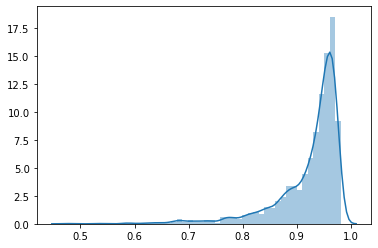

In [109]:
import seaborn as sns

def convert_proba_to_class(probability, thereshold = 0.8):
    return np.where(probability < thereshold, 1, 0)[:,0]

sns.distplot(LGBM_optuna_predicted_test[:, 0])

In [130]:
roc_auc_score(LGBM_predicted_train, train_target)

0.9607375815353738

In [131]:
roc_auc_score(LGBM_predicted_test, test_target)

0.4637318659329665

In [128]:
roc_auc_score(convert_proba_to_class(LGBM_optuna_predicted_train), train_target)

0.8633848034626694

In [129]:
roc_auc_score(convert_proba_to_class(LGBM_optuna_predicted_test), test_target)

0.5857714002355421

In [74]:
roc_auc_score(LGBM_predicted_train, LGBM_optuna_predicted_train)

0.8746864024084295

In [237]:
first_level_output = pd.DataFrame(data=np.array([LGBM_predicted_train, LGBM_optuna_predicted_train]).reshape(len(LGBM_predicted_train), 2), columns=['LGBM', 'LGBM_optuna'])
first_level_output = first_level_output.join(train_full_features.reset_index(drop=True))
first_level_output

,LGBM,LGBM_optuna,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,1,0,445173,0,0,0,1,0,162000.0,619254.0,...,0.0,0.0,0.0,0.0,4.0,-12299.0,-1711.0,1,NaN,0
1,0,0,120419,0,0,0,1,1,202500.0,805536.0,...,0.0,0.0,0.0,0.0,2.0,-19199.0,-4915.0,1,NaN,0
2,0,0,266087,0,0,1,1,0,157500.0,505332.0,...,0.0,0.0,0.0,0.0,1.0,-19446.0,-2813.0,1,NaN,0
3,0,0,200021,0,0,0,1,2,202500.0,260640.0,...,0.0,1.0,0.0,0.0,2.0,-11454.0,-3804.0,1,NaN,0
4,0,0,120701,0,0,0,1,0,54000.0,269550.0,...,NaN,NaN,NaN,NaN,NaN,-19382.0,-1702.0,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,0,234579,0,0,0,1,0,162000.0,891072.0,...,NaN,NaN,NaN,NaN,NaN,-23418.0,-730.0,1,NaN,0
7996,0,0,418107,0,0,1,1,0,180000.0,243000.0,...,0.0,0.0,1.0,0.0,4.0,-16790.0,-8458.0,1,NaN,0
7997,0,0,296083,0,1,1,1,0,247500.0,360000.0,...,0.0,0.0,2.0,0.0,3.0,-19193.0,-1856.0,1,NaN,0
7998,0,0,103189,0,1,0,1,0,225000.0,277969.5,...,0.0,1.0,1.0,0.0,2.0,-15925.0,-1194.0,1,NaN,0


In [238]:
first_level_output_test = pd.DataFrame(data=np.array([LGBM_predicted_test, LGBM_optuna_predicted_test]).reshape(len(LGBM_predicted_test), 2), columns=['LGBM_test', 'LGBM_optuna_test'])
first_level_output_test = first_level_output_test.join(test_full_features.reset_index(drop=True))
first_level_output_test

,LGBM_test,LGBM_optuna_test,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,0,0,220929,0,1,0,1,1,181084.5,1350000.0,...,0.0,0.0,0.0,0.0,2.0,-9993.0,-1087.0,1,NaN,0
1,0,0,200351,0,1,0,1,1,270000.0,1563840.0,...,0.0,0.0,1.0,0.0,1.0,-11812.0,-1106.0,1,NaN,0
2,0,0,198362,0,0,0,0,0,157500.0,1303812.0,...,NaN,NaN,NaN,NaN,NaN,-22647.0,-730.0,1,NaN,0
3,0,0,391215,0,0,0,1,0,180000.0,364896.0,...,0.0,0.0,0.0,2.0,3.0,-19471.0,-2032.0,1,NaN,0
4,0,0,141764,0,1,0,1,0,202500.0,1293502.5,...,0.0,0.0,0.0,1.0,2.0,-16047.0,-4234.0,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,233950,1,0,0,1,0,135000.0,270000.0,...,0.0,0.0,0.0,0.0,0.0,-12213.0,-2521.0,1,NaN,0
1996,0,0,156548,0,0,0,1,0,157500.0,254700.0,...,0.0,0.0,0.0,2.0,0.0,-25020.0,-730.0,1,NaN,0
1997,0,0,259136,0,0,0,1,0,180000.0,711612.0,...,0.0,1.0,2.0,0.0,3.0,-17186.0,-3575.0,1,NaN,0
1998,0,0,198267,0,0,0,1,0,112500.0,490495.5,...,0.0,0.0,0.0,0.0,0.0,-20786.0,-2569.0,1,NaN,0


#### Second Level

In [239]:
lgbc=LGBMClassifier(**default_params)
lgbc.fit(first_level_output, train_target)
predicted_train = lgbc.predict(first_level_output)
predicted_test = lgbc.predict(first_level_output_test)

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [240]:
pd.Series(predicted_train).value_counts()

0    7347
1     653
dtype: int64

In [241]:
pd.Series(predicted_test).value_counts()

0    1988
1      12
dtype: int64

In [242]:
roc_auc_score(predicted_test, test_target.values)

0.505449362843729

In [243]:
roc_auc_score(predicted_train, train_target.values)

0.9999319450115693